In [1]:
import sys
import os 
sys.path.append(os.path.abspath(os.path.join("", "..")))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch import nn
from vanilla_vae import VanillaVAE
import wandb
import gc
import importlib
device = "cuda:0"

In [2]:
import torch
import gc
torch.cuda.empty_cache()
gc.collect()

43

In [3]:
from PIL import Image

## Original image:

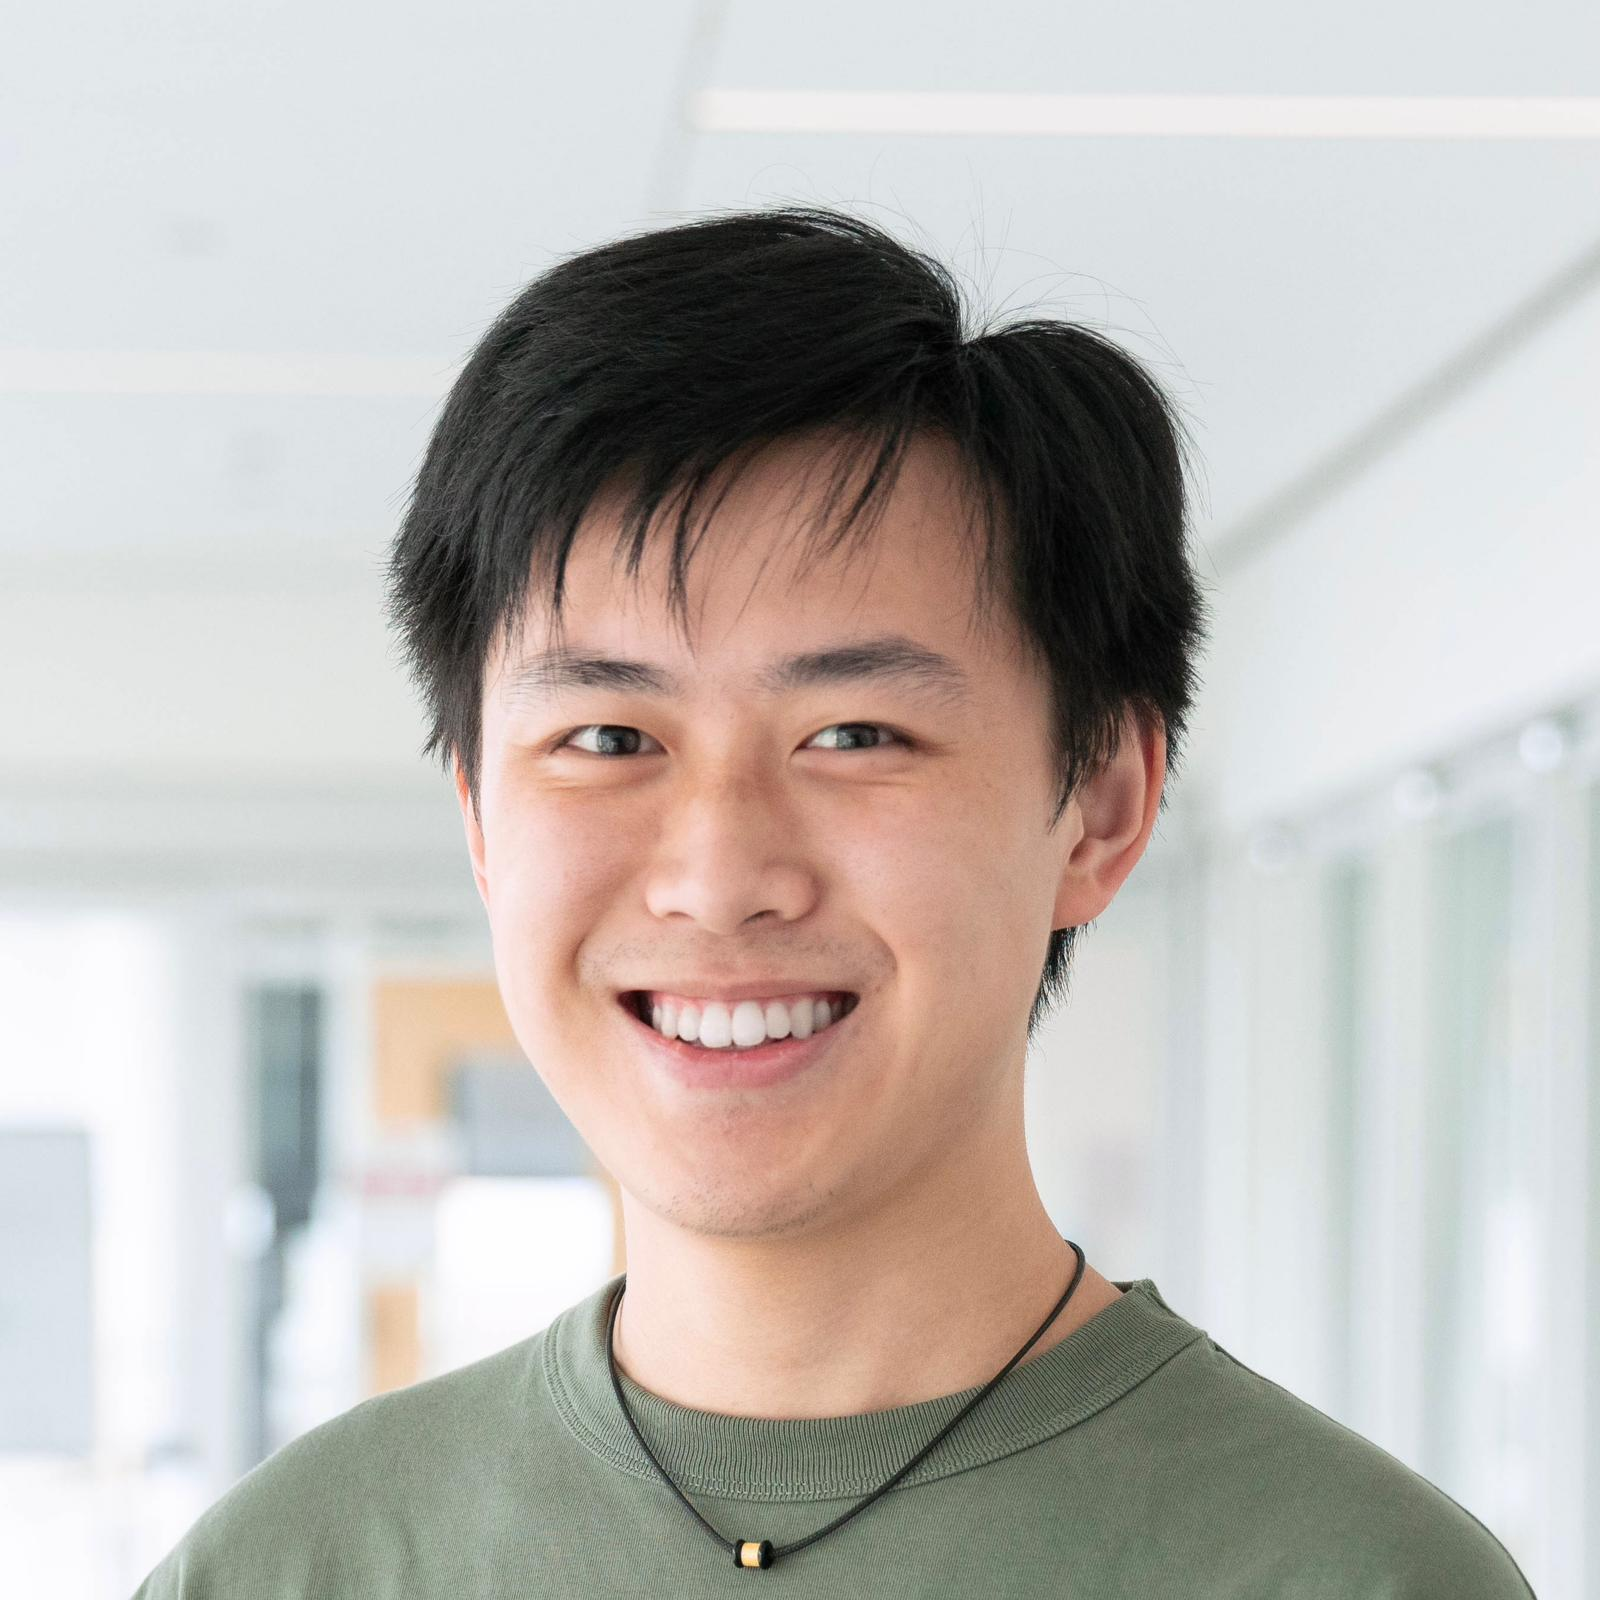

In [4]:
img_path = '../groupfaces/yining/im/person/yining.jpg'
img = Image.open(img_path)
img.show()

## VAE-w2w CMA-ES black-box inversion:

### Step 1: Load VAE-w2w model

In [5]:
# model_save_path = 'temp_vanilla_vae_latent512_beta0.01'

# from vanilla_vae import VanillaVAE

# latent_dim = 512
# beta = 0.01
# hidden_dims=[2048]

# vae_w2w =  VanillaVAE(input_dim=99648, latent_dim=latent_dim, hidden_dims=[2048], beta=beta, batch_norm=False)
# vae_w2w.load_state_dict(torch.load(os.path.join(model_save_path, "model.pt")))
# vae_w2w = vae_w2w.to(device)
# print(f"Model loaded from {model_save_path}")

import vae_w2w.vanilla_vae
importlib.reload(vae_w2w.vanilla_vae)
from vae_w2w.vanilla_vae import VanillaVAE

normalize_by_10 = True
batch_norm = False
latent_dim = 512
yining_hidden_dims = [2048, 1024]
yuchen_hidden_dims = [4096, 2048, 1024]

# yining_vae = VanillaVAE(input_dim=99648, latent_dim=latent_dim,hidden_dims=yining_hidden_dims, batch_norm=False).to(device)
yuchen_vae = VanillaVAE(input_dim=99648, latent_dim=latent_dim,hidden_dims=yuchen_hidden_dims, batch_norm=False).to(device)

yining_model_path = "yining_vae.pt"
yuchen_model_path = "yuchen_vae.pt"

yuchen_state_dict = torch.load(yuchen_model_path, map_location=device)
yuchen_vae.load_state_dict(yuchen_state_dict)

# yining_state_dict = torch.load(yining_model_path, map_location=device)
# yining_vae.load_state_dict(yining_state_dict)

print(f"Model loaded from {yuchen_model_path}")

Model loaded from yuchen_vae.pt


### Step 2: Invert

In [6]:
from utils import load_models
unet, diffusion_vae, text_encoder, tokenizer, noise_scheduler = load_models(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [7]:
import lora_VAEw2w
importlib.reload(lora_VAEw2w)
from lora_VAEw2w import LoRAw2wVAE
torch.cuda.empty_cache()
gc.collect()

51

In [8]:
import invert_cmaes
importlib.reload(invert_cmaes)
from invert_cmaes import invert_evo

In [9]:
weight_dimensions_path = "../files/weight_dimensions.pt"
weight_dimensions = torch.load(weight_dimensions_path)

network = LoRAw2wVAE(yuchen_vae, unet).to(device)

total params counted: 99648


In [10]:
print(f"Available GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
print(f"Currently allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
print(f"Max allocated: {torch.cuda.max_memory_allocated() / 1024**3:.2f} GB")

Available GPU memory: 22.18 GB
Currently allocated: 8.27 GB
Max allocated: 8.27 GB


In [11]:
torch.cuda.empty_cache()
gc.collect()

epochs=30
n_samples=10
popsize=24

wandb_proj_name = 'w2w-invert'
wandb_run_name = f'CMAES-yuchenVAE-e{epochs}-samples{n_samples}-popsize{popsize}'

wandb_name = {'proj': wandb_proj_name, 'name': wandb_run_name}

best_z = invert_evo(yuchen_vae, img_path, mask_path=None, device=device, n_epochs=epochs, n_samples=n_samples, popsize=popsize,wandb_name=wandb_name)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]


total params counted: 99648
latent dim: 512
[2024-12-12 09:18:27] INFO     <19407> evotorch.core: Instance of `Problem` (id:132882139387936) -- The `dtype` for the problem's decision variables is set as torch.float32
[2024-12-12 09:18:27] INFO     <19407> evotorch.core: Instance of `Problem` (id:132882139387936) -- `eval_dtype` (the dtype of the fitnesses and evaluation data) is set as torch.float32
[2024-12-12 09:18:27] INFO     <19407> evotorch.core: Instance of `Problem` (id:132882139387936) -- The `device` of the problem is set as cuda:0
[2024-12-12 09:18:27] INFO     <19407> evotorch.core: Instance of `Problem` (id:132882139387936) -- The number of actors that will be allocated for parallelized evaluation is 0


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: fzmautner (fzmautner-carnegie-mellon-university). Use `wandb login --relogin` to force relogin


100%|██████████| 30/30 [12:30<00:00, 25.02s/it]


## Analyze solution

In [20]:
from utils import inference

Generating with LoRAVAEw2w...


  0%|          | 0/51 [00:00<?, ?it/s]

100%|██████████| 51/51 [00:03<00:00, 16.78it/s]


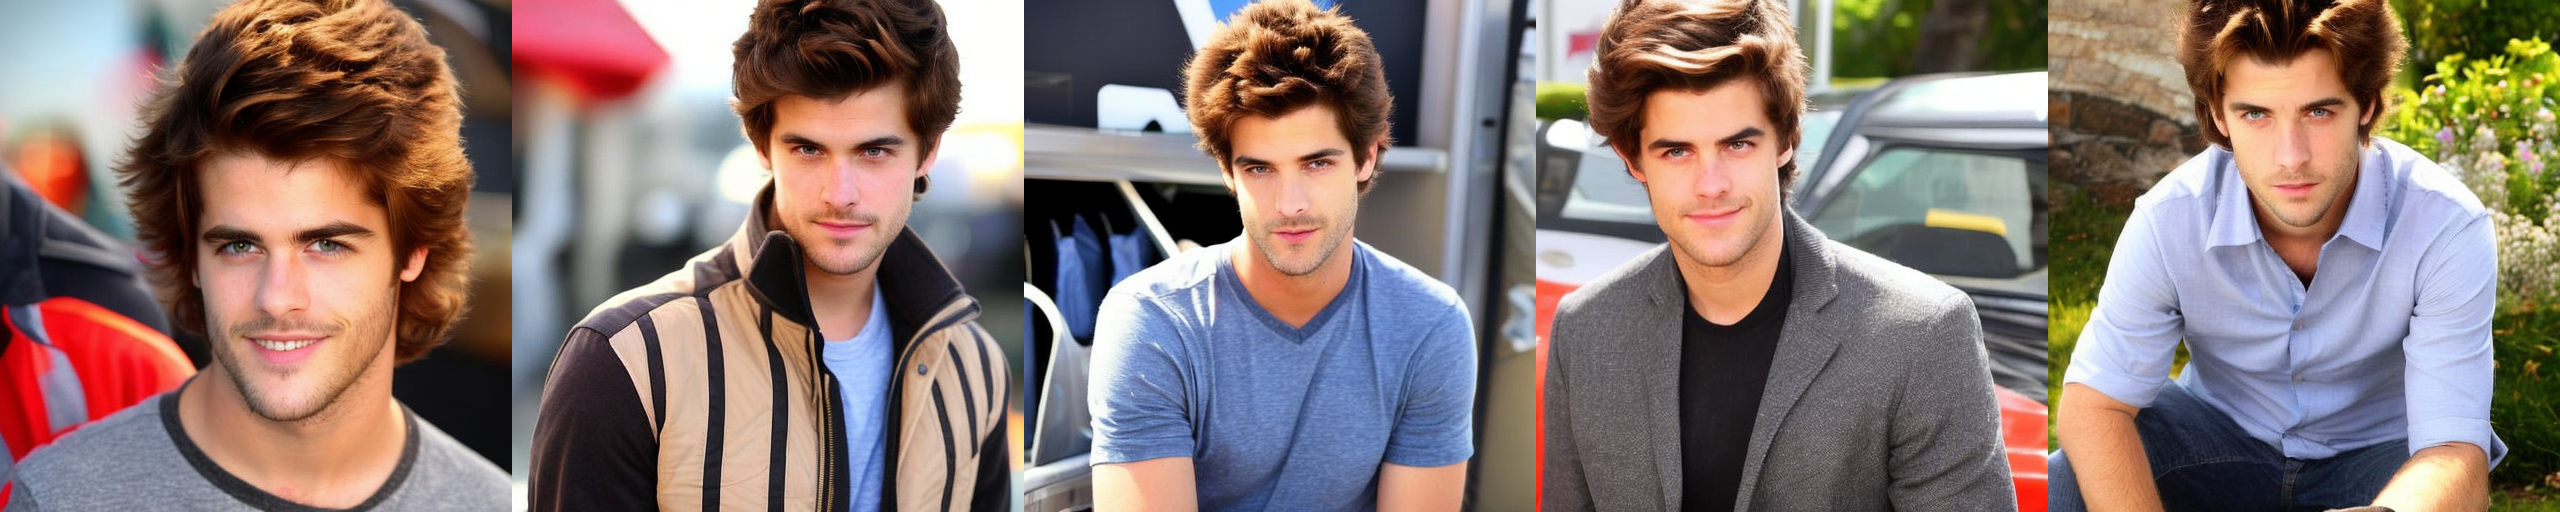

In [21]:
network.z.data = best_z.values
prompt = "sks person"
n_images = 5
seed_start = 10

generation_params = {
        'prompt': prompt,
        'negative_prompt': "low quality, blurry, unfinished",
        'guidance_scale': 3.0,
        'num_inference_steps': 50,
    }
    
# Generate images using both methods
images_direct = []

print("Generating with LoRAVAEw2w...")
for i in range(n_images):
    generator = torch.Generator(device=device)
    generator = generator.manual_seed(seed_start + i)
    
    img = inference(
        network, unet, diffusion_vae, text_encoder, tokenizer,
        prompt=generation_params['prompt'],
        negative_prompt=generation_params['negative_prompt'],
        guidance_scale=generation_params['guidance_scale'],
        noise_scheduler=noise_scheduler,
        ddim_steps=generation_params['num_inference_steps'],
        seed=seed_start + i,
        generator=generator,
        device=device
    )
    
    # Convert to PIL
    img = (img.cpu().permute(0, 2, 3, 1) * 255).to(torch.uint8)[0].numpy()
    images_direct.append(Image.fromarray(img))

# Create image grid
image_size = 512  # Fixed image size
num_cols = 5  # Fixed width of 5 images
num_rows = (len(images_direct) + num_cols - 1) // num_cols  # Ceiling division for number of rows
grid = Image.new('RGB', (num_cols * image_size, num_rows * image_size))

# Paste images into grid
for idx, img in enumerate(images_direct):
    x = (idx % num_cols) * image_size
    y = (idx // num_cols) * image_size
    grid.paste(img, (x, y))

display(grid)